# IO


In this lab you will be testing different IO strategies and their impact on performance. I will provide code snippets on how to read and write to different devices.Your job is to use these code blocks to write a testing suite that tests compares the effect of different reading and writing strategies.

## Getting started

You will need to do this lab on the SLURM cluster. Begin by loging in through Chrome Remote Desktop. Then request exclusive access to one of the compute nodes with X11 support

srun  --x11 --pty --exclusive  -p cpu  /bin/bash 

Activate the python environment in spack 

spack load python

Next clone the repository for the lab and open up this notebook

git clone http://zapad.stanford.edu/GP257/io-lab.git

jupyter notebook notebook.ipynb

Lets begin by creating a large 3-D array in numpy and use the cosine function to create some intersting patterns.

In [1]:
from multiprocessing import Pool
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.cloud import storage
import numba as nb
from io import UnsupportedOperation

In [2]:
# def createData(n1,n2,n3,n1max=math.pi*3,n2max=math.pi*3,n3max=math.pi*3):
#     """
#         A function to create interesting looking data
        
#         n1,n2,n3 - The size of the array
#         n1max,n2max,n3max - The range of each axis. Larger results in more cycles
#     """
#     x=np.cos(np.linspace(0,n1max,n1))
#     y=np.cos(np.linspace(0,n2max,n2))
#     z=np.cos(np.linspace(0,n3max,n3))
#     ar=np.zeros((n3,n2,n1))
#     for i3 in range(n3):
#         for i2 in range(n2):
#             for i1 in range(n1):
#                 ar[i3,i2,i1]=z[i3]+y[i2]+x[i1]
#     return ar

# Numpy speed up version with prange loops
@nb.njit(parallel=True)
def createData(n1, n2, n3, n1max=math.pi*3, n2max=math.pi*3, n3max=math.pi*3):
    """
        A function to create interesting looking data

        n1,n2,n3 - The size of the array
        n1max,n2max,n3max - The range of each axis. Larger results in more cycles
    """
    x = np.cos(np.linspace(0, n1max, n1))
    y = np.cos(np.linspace(0, n2max, n2))
    z = np.cos(np.linspace(0, n3max, n3))
    ar = np.zeros((n3, n2, n1))
    for i3 in nb.prange(n3):
        for i2 in nb.prange(n2):
            for i1 in nb.prange(n1):
                ar[i3, i2, i1] = z[i3] + y[i2] + x[i1]
    return ar

The next cell is going to take significant time. You could always rewrite the loop above in numba speed it up. Meshgrid could also be used but it might take up quite a bit of memory if you aren't careful.

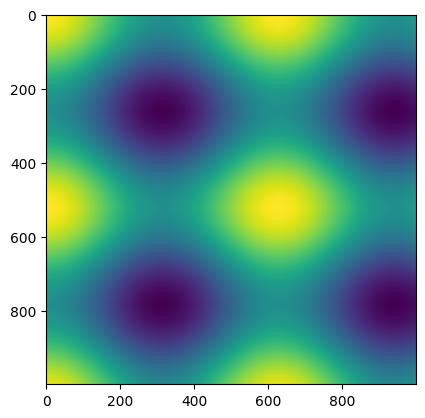

In [3]:
import matplotlib.pyplot as plt

array=createData(1000,1000,1000,10,12,3)
plt.imshow(array[100,:,:])

Below are functions to open files on the three (might want to add ssd) different memory devices that have different properties. The first is the local file system ("/tmp"), the second is a NFS filesystem ("/home"), the third is an object storage system. In each case we wiil return a handler that we will use for writing.

In [4]:
import os
from google.cloud import storage 


#name of files/objects we are going to use
user=os.environ["USER"]
tmpFile=f"/tmp/{user}_destroy"
homeFile=f"/home/scratch/{user}_destroy"
object=f"{user}/destroy"
bucketName="scratch-sep"



#open a file on tmp for read or write
def openLocalRead():
    return open(tmpFile,"rb")
def openLocalWrite():
    return open(tmpFile,"w+b")

#open a file on home for read or write
def openNFSRead():
    return open(homeFile,"rb")
def openNFSWrite():
    return open(homeFile,"wb")

#open object
def openObjectRead():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    if not blob.isok():
        raise Exception("Trouble creating blob")
    return blob.open("rb")
def openObjectWrite():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    return blob.open("wb")



You can use these functions to open different devices that you can write to. Next lets build a series of functions that will read or write a portion our data arrays.

In [5]:
def writeData(fle, array, b1, b2, b3, e1, e2, e3, block_size):
    """
    fle - File handle
    array - Array to read/write to
    b1, b2, b3 - Begin index
    e1, e2, e3 - End index
    block_size - Block size
    
    Note we are making a big assumption of sequential writes
    """
    x = array[b3:e3, b2:e2, b1:e1].tobytes() # get the values in the block to a byte format
    size = min(block_size, e1-b1, e2-b2, e3-b3) # find the minimum value of block size and take diff of dim. sizes
    written = 0 # initlialize the amount of data written to zero
    while written < (e1-b1)*(e2-b2)*(e3-b3)*8: # run the loop as long as not all the data is written
        if written + size*(e1-b1)*(e2-b2)*8 > (e1-b1)*(e2-b2)*(e3-b3)*8: # if we have remaining data less than the block size
            size = ((e1-b1)*(e2-b2)*(e3-b3)*8 - written) // ((e1-b1)*(e2-b2)*8) # total block size in bytes (number of 2d slices)
        fle.write(x[written:written+size*(e1-b1)*(e2-b2)*8]) # size is block size being written, the two dimensions represents total elements in 2-d slice being written
        written += size*(e1-b1)*(e2-b2)*8 # add into the tracker how much data is written
        size = min(block_size, e1-b1, e2-b2, e3-b3) # get the minimum of the block size and differences between end and beginning indices for all three dimensions again


    
def readData(fle, array, b1, b2, b3, e1, e2, e3):
    """
        fle - File handle
        array - Array to read into
        b1,b2,b3 -Begin index 
        e1,e2,e3 - End index
        
        
        Note: We are making a big assumption of sequential reads
    """
    buffer_size = (e3 - b3, e2 - b2, e1 - b1) # temporary read size
    read_buffer = np.frombuffer(fle.read(buffer_size[0] * buffer_size[1] * buffer_size[2] * 8), dtype=array.dtype)
    read_buffer = read_buffer.reshape(buffer_size)
    array[b3:e3, b2:e2, b1:e1] = read_buffer



We can use these functions to write the data to our different storage choices.

In [22]:
tmpF=openLocalWrite()
#writeData(tmpF,array,0,0,0,array.shape[2],array.shape[1],array.shape[0], 50)
tmpF.close()

tmpN=openNFSWrite()
#writeData(tmpN,array,0,0,0,array.shape[2],array.shape[1],array.shape[0], 50)
tmpN.close()

tmpB=openObjectWrite()
writeData(tmpB,array,0,0,0,array.shape[2]*200,array.shape[1],array.shape[2], 50)
tmpB.close()

InvalidResponse: ('Request failed with status code', 403, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.CREATED: 201>)

## What you need to do (pt1)

Using the functions above and what you have learned about timers perform a series of timing tests. In each case you are going read or write the entire dataset in a loop. What is going to change is how much you read or write at a time. Vary the size of your blocks approximately logrthymically staring at 50 samples. Make a chart of performance vs blocksize.

Testing Local storage...
Block size: 10
Write time: 0.019 seconds
Read time: 0.008 seconds
Block size: 10
Write time: 0.013 seconds
Read time: 0.007 seconds
Block size: 12
Write time: 0.012 seconds
Read time: 0.006 seconds
Block size: 13
Write time: 0.011 seconds
Read time: 0.005 seconds
Block size: 14
Write time: 0.011 seconds
Read time: 0.005 seconds
Block size: 15
Write time: 0.010 seconds
Read time: 0.004 seconds
Block size: 17
Write time: 0.009 seconds
Read time: 0.003 seconds
Block size: 19
Write time: 0.010 seconds
Read time: 0.003 seconds
Block size: 21
Write time: 0.009 seconds
Read time: 0.003 seconds
Block size: 23
Write time: 0.009 seconds
Read time: 0.003 seconds
Block size: 25
Write time: 0.008 seconds
Read time: 0.003 seconds
Block size: 28
Write time: 0.008 seconds
Read time: 0.002 seconds
Block size: 30
Write time: 0.008 seconds
Read time: 0.003 seconds
Block size: 33
Write time: 0.009 seconds
Read time: 0.002 seconds
Block size: 37
Write time: 0.008 seconds
Read time:

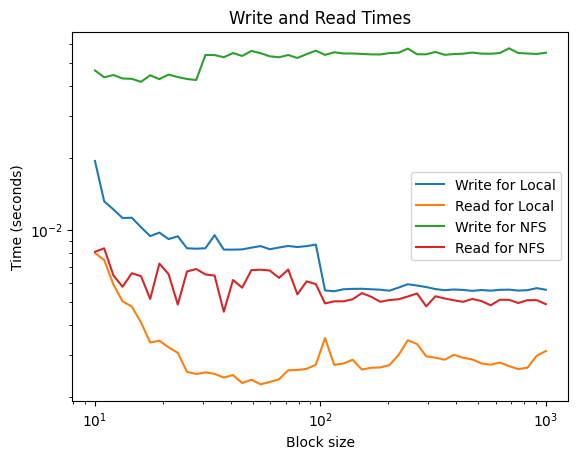

In [13]:
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.cloud import storage
import numba as nb
from io import UnsupportedOperation


# Define the parameters

n1 = 100
n2 = 100
n3 = 100

# Create the data array
array = createData(n1, n2, n3) # generate the data

def time_write(storage_fn, block_size):
    """
    time_write measues the time taken to write a data block of a given size to a storage medium
    """
    start_time = time.time() # start timer
    with storage_fn() as fle: # open the write function as fle for the given storage location, with will close the file after writing the data
        for i1 in range(0, n1, block_size): # loop through to find the portions of the array with the block size amount of samples
            for i2 in range(0, n2, block_size):
                for i3 in range(0, n3, block_size):
                    writeData(fle, array, i1, i2, i3, min(i1+block_size, n1), min(i2+block_size, n2), min(i3+block_size, n3), block_size)
    end_time = time.time() # end timer 
    return end_time - start_time


def time_read(storage_fn_name, block_size):
    start_time = time.time() # start timer
    with storage_fn_name() as fle:
        for i1 in range(0, n1, block_size): # loop through block sizes for reading
            for i2 in range(0, n2, block_size):
                for i3 in range(0, n3, block_size):
                    try:
                        readData(fle, array, i1, i2, i3, min(i1+block_size, n1), min(i2+block_size, n2), min(i3+block_size, n3))
                    except UnsupportedOperation:
                        continue
    end_time = time.time() # end timer 
    return end_time - start_time


# Define the range of block sizes
min_block_size = 10
max_block_size = 1000
num_sizes = 50
log_min = math.log(min_block_size)
log_max = math.log(max_block_size)
log_sizes = np.logspace(log_min, log_max, num=num_sizes, base=math.e) # get log scale of block sizes 

# Define the storage options
# storage_options = [
#     ('Local', openLocalRead, openLocalWrite),
#     ('NFS', openNFSRead, openNFSWrite),
#     ('Object', openObjectRead, openObjectWrite)
# ]
storage_options = [
    ('Local', openLocalRead, openLocalWrite),
    ('NFS', openNFSRead, openNFSWrite),
] # create a list of size 3 tuples to store our storage name, read, and write functions for each storage location


# Measure read/write performance for each storage option and block size
for storage_name, read_fn, write_fn in storage_options: # loop through and perform the read and write time tasks for each storage method
    print(f"Testing {storage_name} storage...") # state which storage method we test
    
    # Store timing data for each block size
    write_times = [] # create a list of write times for each block size
    read_times = []
    
    for block_size in log_sizes: # for each block size calculate the times 
        block_size = int(block_size) # block size 
        print(f"Block size: {block_size}")
        
        # Write the data 
        write_time = time_write(write_fn, block_size) # write time
        print(f"Write time: {write_time:.3f} seconds")
        write_times.append(write_time) #
        
        # Read the data
        read_time = time_read(read_fn, block_size)
        print(f"Read time: {read_time:.3f} seconds")
        read_times.append(read_time)
    
    
   # Plot the write times on the first subplot
    plt.plot(log_sizes, write_times, label=f'Write for {storage_name}')
    plt.plot(log_sizes, read_times, label=f'Read for {storage_name}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Block size')
plt.ylabel('Time (seconds)')
plt.title('Write and Read Times')
plt.legend()
    
plt.show()

        
#         # Read the data
#         read_time = time_read(read_fn, block_size)
#         print(f"Read time: {read_time:.3f} seconds")
#         read_times.append(read_time)

## What you need to do (pt2)

You have learned that parallelism is useful.  Modify the functions above so you are writing to different files/objects and use what you have learned about the multiprocessing module to write the blocks to different files. Star with the assumption that anything smaller than 1MB is probably sub-optimail.  
Hint: You might need to look at the second multiprocessing lab.

Testing Local storage...
Block size: 10
Write time: 0.007 seconds
Read time: 0.003 seconds
Block size: 11
Write time: 0.005 seconds
Read time: 0.003 seconds
Block size: 14
Write time: 0.003 seconds
Read time: 0.002 seconds
Block size: 17
Write time: 0.002 seconds
Read time: 0.001 seconds
Block size: 20
Write time: 0.001 seconds
Read time: 0.001 seconds
Block size: 24
Write time: 0.001 seconds
Read time: 0.001 seconds
Block size: 29
Write time: 0.001 seconds
Read time: 0.001 seconds
Block size: 34
Write time: 0.001 seconds
Read time: 0.001 seconds
Block size: 41
Write time: 0.001 seconds
Read time: 0.001 seconds
Block size: 49
Write time: 0.001 seconds
Read time: 0.001 seconds
Testing NFS storage...
Block size: 10
Write time: 0.028 seconds
Read time: 0.004 seconds
Block size: 11
Write time: 0.018 seconds
Read time: 0.004 seconds
Block size: 14
Write time: 0.015 seconds
Read time: 0.003 seconds
Block size: 17
Write time: 0.014 seconds
Read time: 0.002 seconds
Block size: 20
Write time: 0

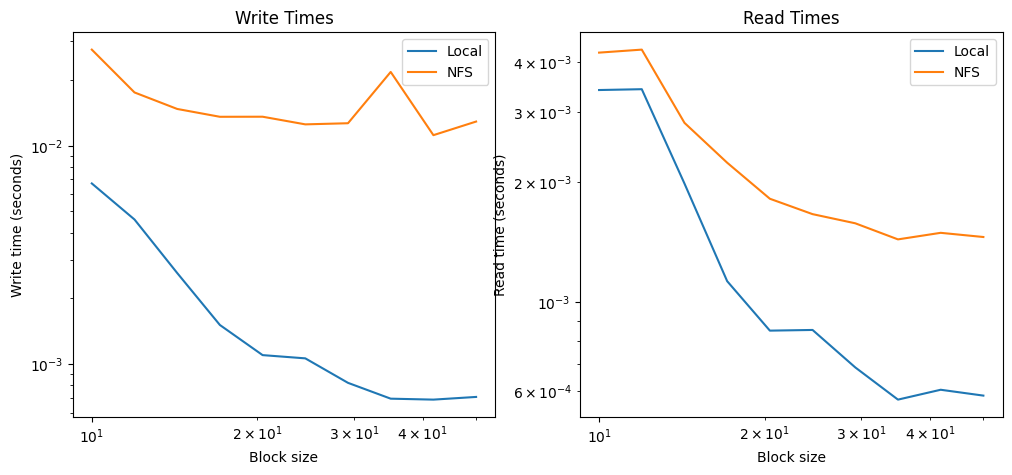

In [14]:
# Define the parameters
n1 = 100
n2 = 100
n3 = 100

# Create the data array
array = createData(n1, n2, n3)

# Define a function where we can now write data to multiple files!
# You can replace the f.write(x[written:written+size*(e1-b1)*(e2-b2)*8]) line in the writeData function 
# with np.save(f, array[b3:e3, b2:e2, b1:e1]) to write to the file using NumPy's save function. 
def writeData(file_path, data, i1, i2, i3, j1, j2, j3, block_size):
    with open(file_path, 'wb') as f:
        np.save(f, data[i1:j1, i2:j2, i3:j3]) # by changing this to np.save, we can write to different files
        
def time_write(storage_fn, block_size):
    start_time = time.time()
    with storage_fn() as fle:
        for i1 in range(0, n1, block_size):
            for i2 in range(0, n2, block_size):
                for i3 in range(0, n3, block_size):
                    file_path = f"data_{i1}_{i2}_{i3}.npy"
                    data = array[i1:min(i1+block_size, n1), i2:min(i2+block_size, n2), i3:min(i3+block_size, n3)]
                    if data.nbytes > 1024*1024: # Check if data size is greater than 1MB
                        writeData(file_path, array, i1, i2, i3, min(i1+block_size, n1), min(i2+block_size, n2), min(i3+block_size, n3), block_size)
    end_time = time.time()
    return end_time - start_time


def time_read(storage_fn_name, block_size):
    start_time = time.time()
    with storage_fn_name() as fle:
        for i1 in range(0, n1, block_size):
            for i2 in range(0, n2, block_size):
                for i3 in range(0, n3, block_size):
                    data = array[i1:min(i1+block_size, n1), i2:min(i2+block_size, n2), i3:min(i3+block_size, n3)]
                    if data.nbytes > 1024*1024:  # Check if data size is greater than 1MB
                        try:
                            readData(fle, array, i1, i2, i3, min(i1+block_size, n1), min(i2+block_size, n2), min(i3+block_size, n3))
                        except UnsupportedOperation:
                            continue
    end_time = time.time()
    return end_time - start_time


# Define the range of block sizes
min_block_size = 10
max_block_size = 50
num_sizes = 10
log_min = math.log(min_block_size)
log_max = math.log(max_block_size)
log_sizes = np.logspace(log_min, log_max, num=num_sizes, base=math.e)

# Define the storage options
# storage_options = [
#     ('Local', openLocalRead, openLocalWrite),
#     ('NFS', openNFSRead, openNFSWrite),
#     ('Object', openObjectRead, openObjectWrite)
# ]
storage_options = [
    ('Local', openLocalRead, openLocalWrite),
    ('NFS', openNFSRead, openNFSWrite),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Measure read/write performance for each storage option and block size
for storage_name, read_fn, write_fn in storage_options:
    print(f"Testing {storage_name} storage...")
    
    # Store timing data for each block size
    write_times = []
    read_times = []
    
    for block_size in log_sizes:
        block_size = int(block_size)
        print(f"Block size: {block_size}")
        
        # Write the data
        # use pool to paralleize the read and write operations
        # we use starmap because 'map' only takes functions that take a single argument
        # starmap takes an iterable of argument tuples and applies each tuple to the function
        # with pool and starmap, we can execute read and write processes for each storage option
        #  and block size in parallel which should reduce the time of performance tests
        with Pool(processes=3) as pool: # create a pool process and specify number of workers
            write_time = sum(pool.starmap(time_write, [(write_fn, block_size)] * 3)) 
            print(f"Write time: {write_time:.3f} seconds")
            write_times.append(write_time)
        
        # Read the data
        with Pool(processes=3) as pool:
            read_time = sum(pool.starmap(time_read, [(read_fn, block_size)] * 3))
            print(f"Read time: {read_time:.3f} seconds")
            read_times.append(read_time)
        
   # Plot the write times on the first subplot
    ax1.plot(log_sizes, write_times, label=storage_name)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Block size')
    ax1.set_ylabel('Write time (seconds)')
    ax1.set_title('Write Times')
    ax1.legend()
    
    # Plot the read times on the second subplot
    ax2.plot(log_sizes, read_times, label=storage_name)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Block size')
    ax2.set_ylabel('Read time (seconds)')
    ax2.set_title('Read Times')
    ax2.legend()
    
plt.show()

## Going beyond (optional)

Data is often compressible. Take a look at https://computing.llnl.gov/projects/zfp. Assuming some tollerance error add in compression/decompression and compare.


## Finishing up


Summarize what you learned in this lab. How does it effect your code design in the future?

**I find this entire exercise very useful. Here I had two tasks to complete the first being the non multiprocessing code that loops over the data to read and write an entire 3D data set and nested loop. the code provided 3 storage options, one to the local disk one through NFS, and the other to a Google cloud bucket or we have the option to read and write from each. I then developed a way to test the time it takes to read and write the data for each block and storage option.  I found doing this very useful as the 3D data set could be very comparable to a large 3D seismic data set that usually without breaking up the data into blocks would be a very mundane task and take a lot of valuable time to read and write. I had to develop a way to create two functions that would utilize the already written writeData and readData functions to measure the time to write a data block of a given size to a storage medium by looping through different block sizes in order to write or read according to each block size. Then for each storage method and for each block size in a list of log block sizes, I called my written time_write and time_read functions and displayed their values for debugging and created a plot displaying the write and read times. If we look at the plot we can see that the code shows that writing an object into a Google cloud bucket takes the longest time, followed by NFS, and local storage takes the least time. These plots also show that dividing out the data set into smaller blocks can increase the number of operations needed. Thus a larger block size seems to be more efficient. For example, if you are reading a 1000x1000x1000 array with a block size of 50, you would need to read and write data 20x20x20 times (or 8000 operations). If you increase the block size to 200, you would only need to read and write data 5x5x5 times (or 125 operations). However, there is a tradeoff between blocksize and memory usage. The larger the block size, the more memory you need to store the data so we need to choose a balance of block size with a comparable memory of the machine we are using.**

**When utilizing the multiprocessing code, I was able to use the multiprocessing module to perform these read and write tasks much more efficiently. the pool function in the multiprocessing is used to create three processes, where there is one for each storage option, that will be read or write in parallel. The star map function in the multiprocessing is used in conjunction with the time_write and time_read functions to send the function and block size parameters as tuples to the pool function. Using multiprocessing the code is able to perform the read and write tests much more efficiently than using just a single process as noted by the plots I was able make to show that we were able to reach an order of magnitude of 10^-3 seconds  for some of the write and read times which was much faster compared to the non-multiprocessing code.**

**The performance differences between the storage options are very significant and using the multiprocessing can speed up the write and read processes even further. By being able to run multiple tasks on separate CPUs we can end up seeding the overall execution time by a large factor.**

**Going forward using multiprocessing for read and write tests on large datasets is going to be definitely high on my recommendation list, especially when dealing with the different storage options. I definitely think the multiprocessing code design will be considered depending upon the total CPUs I have available as well as the memory usage.**